# Deconvolution

In the following the PPMI RNA-Seq (project 133) data are prepared for Deconvolution via Scaden. The preparation is to actually translate the ensembl id's to gene symbols, and to transpose the dataset for it to be processable via scaden. The deconvolution is performed in the commandline. Right after the results are available by scaden's prediction step, the according file is loaded into this notebook and PCA is performed and the appropriate plots generated. A further plot visualizes the proportions of each celltype for all of the cohorts.

In [1]:
!pip install anndata


In [2]:
import pandas as pd

bulk_feature_counts = pd.read_csv("/Volumes/Elements/PPMI_Project_133_RNASeq/ppmi_counts_meta_dataset.csv", index_col=0)

In [25]:
import anndata as ad
import numpy as np

ppmi_adata = ad.AnnData(bulk_feature_counts.iloc[:,bulk_feature_counts.columns.str.startswith("ENSG")])
ppmi_adata.obs['Sample'] = bulk_feature_counts[['Sample']]
ppmi_adata.obs['Diagnosis'] = bulk_feature_counts[['Diagnosis']]
ppmi_adata.obs['Visit'] = bulk_feature_counts[['Visit']]
ppmi_adata.obs['Gender'] = bulk_feature_counts[['Gender']]
ppmi_adata.obs['Patient'] = bulk_feature_counts[['Patient']]
ppmi_adata.layers['counts_log2'] = np.log2(ppmi_adata.X + 1)

In [26]:
ppmi_adata.write_h5ad("/Volumes/Elements/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

In [3]:
counts_raw = bulk_feature_counts.iloc[:,bulk_feature_counts.columns.str.startswith("ENSG")]
counts_raw_t = counts_raw.T

In [4]:
import re
trunc_eid = [re.sub(r"\.\d+$", "", eid) for eid in counts_raw_t.index.values.tolist()]

In [5]:
!pip install mygene

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 623.8 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 777.4 kB/s eta 0:00:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 782.5 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 768.3 kB/s eta 0:00:000:00:01


In [6]:
import mygene

mg = mygene.MyGeneInfo()
mappings = mg.querymany(
    trunc_eid,
    scopes="ensembl.gene",
    fields="symbol",
    species="human"
)
import pandas as pd
df = pd.DataFrame(mappings)
df = df[['query', 'symbol']].rename(columns={'query': 'Ensembl_ID', 'symbol': 'Gene_Symbol'})
print(df[df['Gene_Symbol'].isna()])

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
31 input query terms found dup hits:	[('ENSG00000228044', 2), ('ENSG00000226506', 2), ('ENSG00000261600', 2), ('ENSG00000234162', 2), ('E
1428 input query terms found no hit:	['ENSG00000238009', 'ENSG00000230699', 'ENSG00000241180', 'ENSG00000236948', 'ENSG00000277726', 'ENS


            Ensembl_ID Gene_Symbol
9      ENSG00000238009         NaN
10     ENSG00000239945         NaN
12     ENSG00000268903         NaN
13     ENSG00000269981         NaN
14     ENSG00000239906         NaN
...                ...         ...
58820  ENSG00000276312         NaN
58831  ENSG00000278573         NaN
58832  ENSG00000276017         NaN
58833  ENSG00000278817         NaN
58834  ENSG00000277196         NaN

[14334 rows x 2 columns]


In [8]:
df['Gene_Symbol'] = df['Gene_Symbol'].fillna(df['Ensembl_ID'])

In [9]:
dup_counts = df['Ensembl_ID'].value_counts()
print(f"Total duplicates: {len(dup_counts[dup_counts > 1])}")
print(dup_counts[dup_counts > 1])

df_deduped = df.drop_duplicates(subset=['Ensembl_ID'], keep='first')
print(f"Unique mappings: {len(df_deduped)}")

Total duplicates: 31
Ensembl_ID
ENSG00000275757    10
ENSG00000273730    10
ENSG00000275405     4
ENSG00000276241     4
ENSG00000277927     3
ENSG00000268674     3
ENSG00000278294     3
ENSG00000285761     3
ENSG00000278932     3
ENSG00000262352     3
ENSG00000268595     2
ENSG00000275496     2
ENSG00000280018     2
ENSG00000259182     2
ENSG00000226519     2
ENSG00000257545     2
ENSG00000228566     2
ENSG00000284116     2
ENSG00000234352     2
ENSG00000188660     2
ENSG00000233656     2
ENSG00000249738     2
ENSG00000215156     2
ENSG00000250406     2
ENSG00000243620     2
ENSG00000227110     2
ENSG00000282304     2
ENSG00000234162     2
ENSG00000261600     2
ENSG00000226506     2
ENSG00000228044     2
Name: count, dtype: int64
Unique mappings: 58780


In [10]:
counts_raw_export = counts_raw_t.reset_index(drop=False)

counts_raw_export['index'] = trunc_eid

counts_raw_export = counts_raw_export.rename(columns={'index':'Ensembl_ID'})

In [ ]:
counts_raw_export = (
    counts_raw_export.merge(df_deduped, on='Ensembl_ID', how='left')
    .set_index('Gene_Symbol')
    .drop(columns=['Ensembl_ID'])
)

In [17]:

counts_raw_export.head()

,3174.V08.0000373111.5104.SL.0001,3201.BL.PP0016.0526.5104.SL.0002,3057.V06.0003125874.5104.SL.0003,4126.V04.0003179818.5104.SL.0004,4117.BL.0003164601.5104.SL.0005,3057.V04.0003119973.5104.SL.0006,3471.BL.PP0015.6713.5104.SL.0007,3174.V04.0003162443.5104.SL.0008,3661.V04.0003169393.5104.SL.0009,3551.V06.0003158673.5104.SL.0010,...,41375.V02.0003314306.5104.SL.4885,41292.V04.0003314317.5104.SL.4886,41356.V02.0003314328.5104.SL.4887,41296.V02.0003314372.5104.SL.4888,41294.V04.0003314383.5104.SL.4889,41314.V02.0003314545.5104.SL.4890,42308.V02.0003376702.5104.SL.4891,42306.V02.0003376763.5104.SL.4892,1009.POOL.0003203630.5104.SL.4893,1010.POOL.0003202476.5104.SL.4894
Gene_Symbol,,,,,,,,,,,,,,,,,,,,,
DDX11L1,15,2,0,6,0,17,0,8,0,1,...,1,4,7,3,8,10,20,6,4,6
WASH7P,232,199,148,216,95,112,97,199,232,209,...,59,160,386,114,111,215,217,142,147,182
MIR6859-1,15,10,2,16,3,13,8,0,7,5,...,9,32,39,6,24,14,54,48,21,16
MIR1302-2HG,0,0,1,0,0,3,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
MIR1302-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
import csv
counts_raw_export.to_csv("/Volumes/Elements/PPMI_Project_133_RNASeq/ppmi_133_rna_counts_for_deconv.tsv", sep="\t", quoting=csv.QUOTE_NONE)

In [23]:
scaden_results = pd.read_csv("/Volumes/Elements/PPMI_Project_133_RNASeq/scaden_predictions.txt", sep="\t", index_col=0)

In [24]:
scaden_results.head()


,Monocytes,Unknown,CD4Tcells,Bcells,NK,CD8Tcells
3174.V08.0000373111.5104.SL.0001,0.151065,0.135463,0.200819,0.163410,0.149005,0.200238
3201.BL.PP0016.0526.5104.SL.0002,0.150898,0.136774,0.194329,0.164186,0.151894,0.201919
3057.V06.0003125874.5104.SL.0003,0.151022,0.136971,0.195825,0.164635,0.151027,0.200520
4126.V04.0003179818.5104.SL.0004,0.148983,0.137926,0.193983,0.164917,0.152489,0.201701
4117.BL.0003164601.5104.SL.0005,0.150101,0.137624,0.198422,0.162787,0.149906,0.201160


In [29]:
scaden_results['Diagnosis'] = ppmi_adata.obs['Diagnosis']
scaden_results['Gender'] = ppmi_adata.obs['Gender']
scaden_results.head()

,Monocytes,Unknown,CD4Tcells,Bcells,NK,CD8Tcells,Diagnosis,Gender
3174.V08.0000373111.5104.SL.0001,0.151065,0.135463,0.200819,0.163410,0.149005,0.200238,PD,Male
3201.BL.PP0016.0526.5104.SL.0002,0.150898,0.136774,0.194329,0.164186,0.151894,0.201919,Control,Female
3057.V06.0003125874.5104.SL.0003,0.151022,0.136971,0.195825,0.164635,0.151027,0.200520,Control,Female
4126.V04.0003179818.5104.SL.0004,0.148983,0.137926,0.193983,0.164917,0.152489,0.201701,PD,Male
4117.BL.0003164601.5104.SL.0005,0.150101,0.137624,0.198422,0.162787,0.149906,0.201160,PD,Female


In [44]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
X = scaden_results.drop(columns=['Diagnosis', 'Gender'])
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(data=X_pca)
pca_df[['Diagnosis', 'Gender']] = scaden_results[['Diagnosis', 'Gender']].reset_index(drop=True)

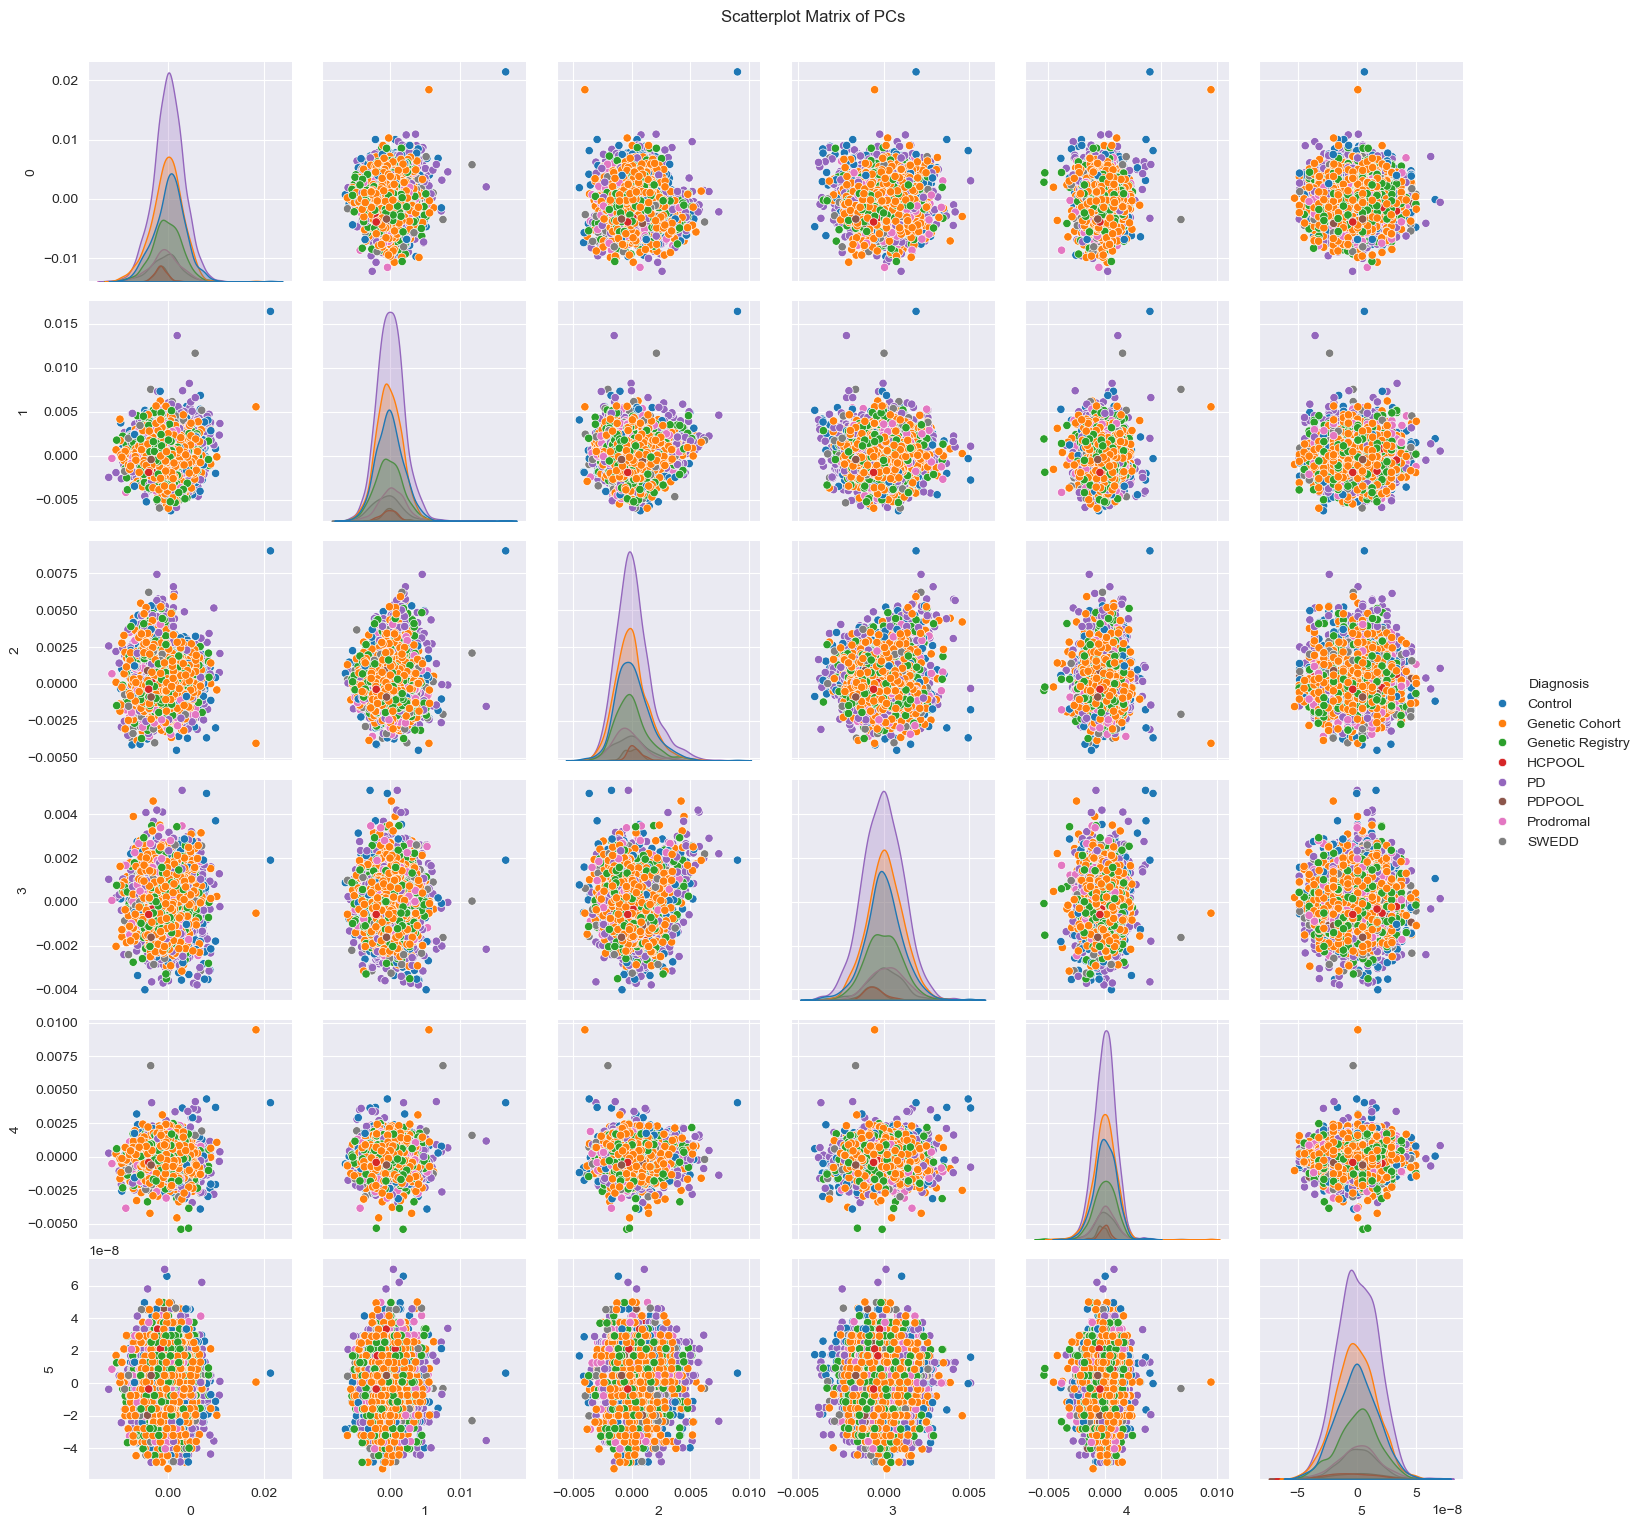

In [52]:
sns.pairplot(pca_df, hue='Diagnosis', diag_kind="kde")
plt.suptitle('Scatterplot Matrix of PCs', y=1.02)
plt.show()

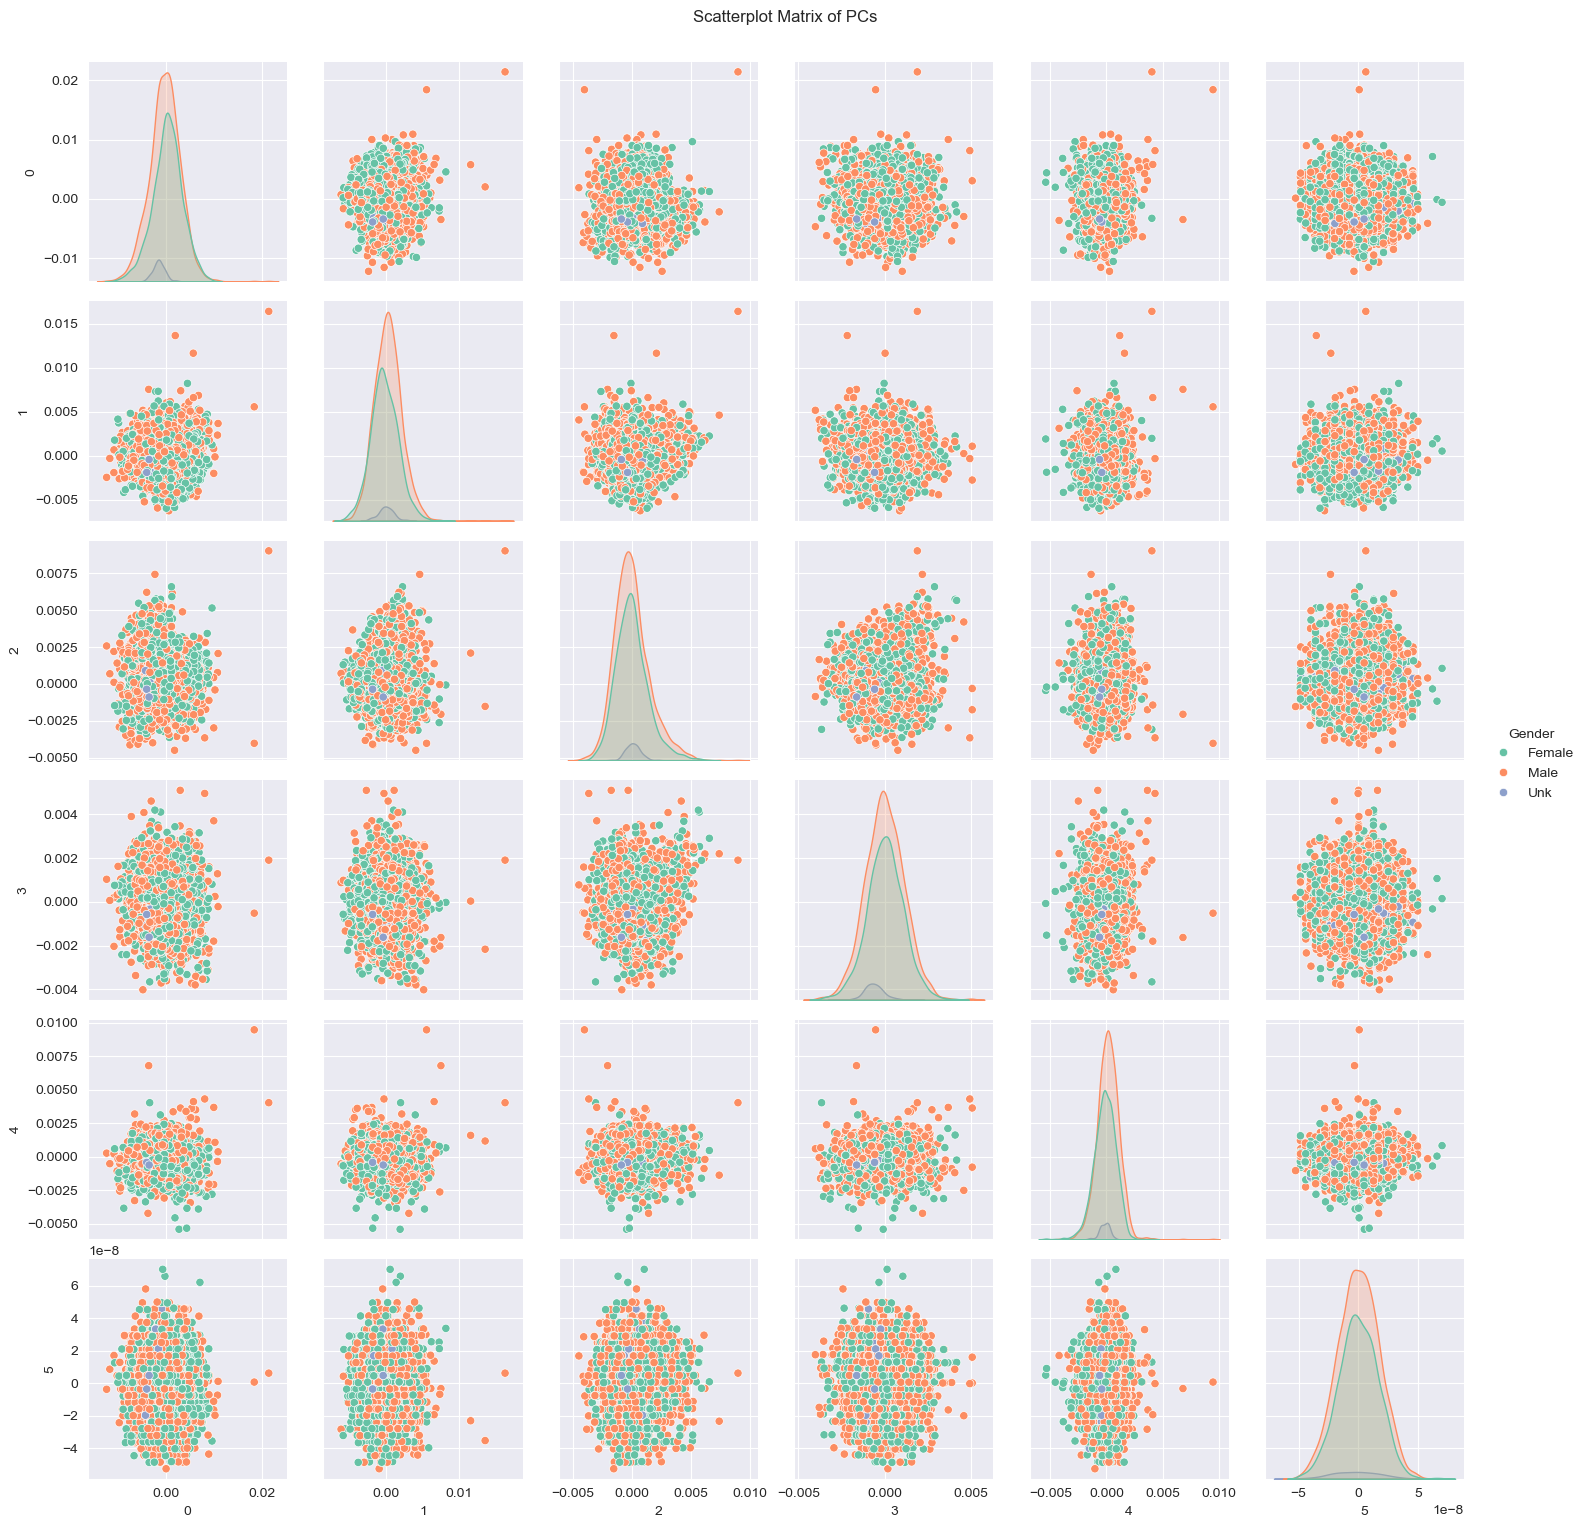

In [47]:
sns.pairplot(pca_df, hue='Gender', palette='Set2', diag_kind="kde")
plt.suptitle('Scatterplot Matrix of PCs', y=1.02)
plt.show()

In [55]:
melted_df = scaden_results.melt(
    id_vars=["Diagnosis"],
    value_vars=["Monocytes", "Unknown", "CD4Tcells", "CD8Tcells", "Bcells", "NK"],
    var_name="CellType",
    value_name="Proportion"
)

# Group by Diagnosis and CellType to get mean proportions
grouped_df = melted_df.groupby(["Diagnosis", "CellType"], as_index=False).mean()

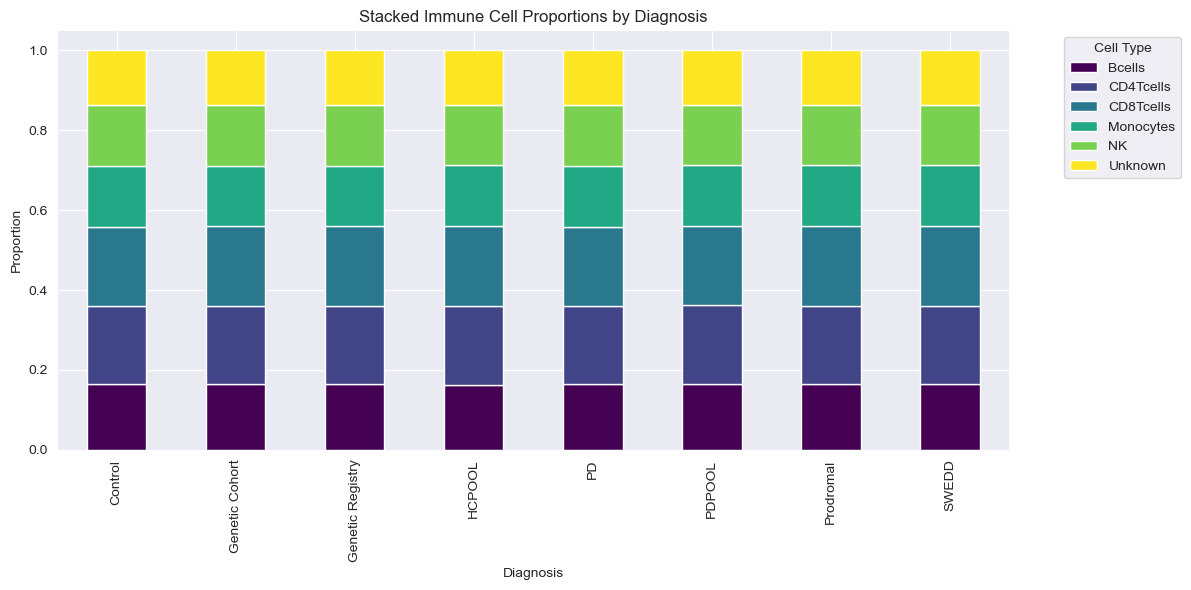

In [56]:
pivot_df = grouped_df.pivot(index="Diagnosis", columns="CellType", values="Proportion")

pivot_df.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Stacked Immune Cell Proportions by Diagnosis")
plt.ylabel("Proportion")
plt.xlabel("Diagnosis")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [58]:
cibersortx_df = pd.read_csv("/Volumes/Elements/PPMI_Project_133_RNASeq/CIBERSORTx_Job6_Results.csv", index_col=0)

In [59]:
cibersortx_df.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,,,,,,,,,,,
3174.V08.0000373111.5104.SL.0001,0.005974,0.005487,0.000000,0.0,0.270177,0.100864,0.016962,0,0.0,0.0,...,0.0,0.0,0.000142,0.013317,0.0,0.0,0.250853,0,0.885423,0.573993
3201.BL.PP0016.0526.5104.SL.0002,0.042858,0.000000,0.000000,0.0,0.171549,0.129150,0.013136,0,0.0,0.0,...,0.0,0.0,0.002955,0.011056,0.0,0.0,0.381806,0,0.877031,0.546133
3057.V06.0003125874.5104.SL.0003,0.024895,0.000000,0.000989,0.0,0.140564,0.129842,0.016171,0,0.0,0.0,...,0.0,0.0,0.006567,0.004951,0.0,0.0,0.406018,0,0.896974,0.514527
4126.V04.0003179818.5104.SL.0004,0.008782,0.000000,0.000000,0.0,0.174572,0.084512,0.016647,0,0.0,0.0,...,0.0,0.0,0.000737,0.006639,0.0,0.0,0.386019,0,0.863534,0.549632
4117.BL.0003164601.5104.SL.0005,0.021231,0.000000,0.000000,0.0,0.255820,0.093761,0.010232,0,0.0,0.0,...,0.0,0.0,0.001050,0.010539,0.0,0.0,0.302367,0,0.872240,0.573251


In [60]:
cibersortx_df.shape

(4756, 25)

In [63]:
cibersortx_df[['Diagnosis', 'Gender']] = ppmi_adata.obs[['Diagnosis', 'Gender']]

In [64]:
cibersortx_df.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value,Correlation,RMSE,Diagnosis,Gender
Mixture,,,,,,,,,,,,,,,,,,,,,
3174.V08.0000373111.5104.SL.0001,0.005974,0.005487,0.000000,0.0,0.270177,0.100864,0.016962,0,0.0,0.0,...,0.000142,0.013317,0.0,0.0,0.250853,0,0.885423,0.573993,PD,Male
3201.BL.PP0016.0526.5104.SL.0002,0.042858,0.000000,0.000000,0.0,0.171549,0.129150,0.013136,0,0.0,0.0,...,0.002955,0.011056,0.0,0.0,0.381806,0,0.877031,0.546133,Control,Female
3057.V06.0003125874.5104.SL.0003,0.024895,0.000000,0.000989,0.0,0.140564,0.129842,0.016171,0,0.0,0.0,...,0.006567,0.004951,0.0,0.0,0.406018,0,0.896974,0.514527,Control,Female
4126.V04.0003179818.5104.SL.0004,0.008782,0.000000,0.000000,0.0,0.174572,0.084512,0.016647,0,0.0,0.0,...,0.000737,0.006639,0.0,0.0,0.386019,0,0.863534,0.549632,PD,Male
4117.BL.0003164601.5104.SL.0005,0.021231,0.000000,0.000000,0.0,0.255820,0.093761,0.010232,0,0.0,0.0,...,0.001050,0.010539,0.0,0.0,0.302367,0,0.872240,0.573251,PD,Female
